# Overview
In order to find the features that can explain the disparity in snap peneration/coverage across tracts in Hennepin County and throw light on the next step for the business partners, we
- Extract features including key demographic and economic features, supplimental family composition and ethinicity group features, as well as supply - the number of snap stores in the neighborhood
- Use multiple linear regression technique to examine important features that positively/negatively associated with snap penetration

## Setup

In [1]:
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.tools.tools as st
import matplotlib.pyplot as plt
import seaborn as sns

## Load SNAP Penetration
Results from Eligibility Population.ipynb

In [2]:
df_el = pd.read_csv('list.csv')
df_el = df_el[['GEO_ID','penetration_v']].rename({'GEO_ID':'tract','penetration_v':'snap_coverage'},axis='columns')

## Input Features 

### a. Key Demographic and Economic features 
- Extract from tract-dict.xlsx key demographic and economic features
- Data source: http://www.mnhousing.gov/sites/np/2019profiles

In [3]:
a = pd.read_excel('tract-dict.xlsx','MHFA_Tract')
selected_cols = ['GEOID2',
                 'HHINC','COSTBALL','POVERTY',
                 'OWNER','HOMELESS','HOCOSTS','SALE','RENT',
                 'TRAVEL']
renamed_cols = ['tract',
                'median_household_income','high_housing_cost','poverty_rate',
                'percent_of_ownership','homeless_rate','median_monthly_mortgage','median_home_sale_price','median_rent',
                'median_travel_distance']
a = a[selected_cols]
a = a.rename({pair[0]:pair[1] for pair in zip(selected_cols,renamed_cols)},axis='columns')


### b. Family Composition and Ethnicity features from Census data
- Data file is generated based on https://data.census.gov/cedsci/table?q=poverty&g=0500000US27053.140000&tid=ACSST5Y2018.S1701&hidePreview=false

In [4]:
b = pd.read_csv('Hennepin_tract_all_selected_features.csv')
b['Under 18 years'] = b['Under 5 years'] + b['5 to 17 years']

### c. Family Receiving Other Government Benefits
Introduced the data of family receiving other government benefits https://data.census.gov/cedsci/table?q=poverty&g=0500000US27053.140000&tid=ACSST5Y2019.S1702&hidePreview=false

In [5]:
c = pd.read_csv('family_receive.csv')
c['cash_public_ass'] = c.iloc[:,3]/c.iloc[:,2]
c['SSI'] = c.iloc[:,4]/c.iloc[:,2]
c = c[['GEO_ID','cash_public_ass','SSI']]

### d. Number of SNAP Stores in each tract
Introduced the number of SNAP partnered stores in each tract 
Data source:
- Snap stores geolocation https://www.fns.usda.gov/snap/retailer-locator
- Border line of each tract in H county https://catalog.data.gov/dataset/tiger-line-shapefile-2018-state-minnesota-current-census-tract-state-based

In [6]:
stores = pd.read_csv('num_of_stores.csv')

### Merge data together

In [7]:
data = pd.merge(df_el,pd.merge(a,b))
supplemental_f = pd.merge(c,stores,left_on='GEO_ID',right_on='GEOID',how='left')
supplemental_f = supplemental_f.drop('GEOID',axis=1)
supplemental_f = supplemental_f.rename({'GEO_ID':'tract'},axis=1)
supplemental_f = supplemental_f.fillna(0)
data = pd.merge(data,supplemental_f)

## Modeling

### Initialization

In [8]:
# Remove extreme valuess
temp = data[~(data['snap_coverage']>1)]

Y = temp['snap_coverage'].reset_index()['snap_coverage']
X = temp.iloc[:,2:]
X['High school graduate or college associate degree'] = X['High school graduate (includes equivalency)'] + \
  X["Some college, associate's degree"]  
X = X.drop(columns=['Female','RACE_White alone',
                    "Less than high school graduate",
                    "Bachelor's degree or higher",
                    'homeless_rate','poverty_rate','median_home_sale_price',
                    'percent_of_ownership',
                    'cash_public_ass','SSI',
                    'Under 5 years','5 to 17 years','18 to 34 years'])
X = X.fillna(0)

### Normalization

In [9]:
scaler = StandardScaler().fit(X)
train_X = scaler.transform(X)

### For reference: feature selection using RFE

In [10]:
# feature selection - RFE
for i in range(10,21):
    selector = RFE(LinearRegression(),n_features_to_select=i, step=1)
    selector = selector.fit(X,Y)
    feature_list = selector.support_
    features = X.columns[feature_list]
    reg = LinearRegression().fit(train_X[:,feature_list],Y)
    s = reg.score(train_X[:,feature_list],Y)
    print(i,s)

10 0.32855654712781135
11 0.3443197910908724
12 0.3444083377943489
13 0.345276319852433
14 0.34541126984260206
15 0.34541126984260206
16 0.34547678989751573
17 0.345613782221856
18 0.3711219175239777
19 0.37290593640895575
20 0.3747731350776874


In [11]:
# choose n_features_to_select = n
selector = RFE(LinearRegression(),n_features_to_select=18, step=1)
selector = selector.fit(X,Y)
feature_list = selector.support_
features = X.columns[feature_list]

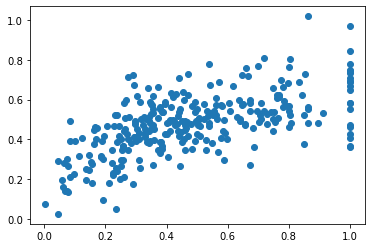

In [28]:
# show predictions
reg = LinearRegression().fit(train_X[:,feature_list],Y)
pre = reg.predict(train_X[:,feature_list])
coef = reg.coef_
plt.scatter(Y,pre)
plt.show()

### Linear Regression Model, using stats.api to output coefs and p-values

In [12]:
selected_X = pd.DataFrame(data=train_X[:,feature_list],columns=features)
selected_X = selected_X.drop(columns=[])
x = st.add_constant(selected_X)
mod = sm.OLS(Y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          snap_coverage   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     9.581
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           1.03e-19
Time:                        21:58:16   Log-Likelihood:                 58.533
No. Observations:                 294   AIC:                            -81.07
Df Residuals:                     276   BIC:                            -14.76
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

### Check collinearity

In [13]:
temp.corr()

,tract,snap_coverage,median_household_income,high_housing_cost,poverty_rate,percent_of_ownership,homeless_rate,median_monthly_mortgage,median_home_sale_price,median_rent,...,RACE_Two or more races,Less than high school graduate,High school graduate (includes equivalency),"Some college, associate's degree",Bachelor's degree or higher,Unemployment,Under 18 years,cash_public_ass,SSI,num_of_stores
tract,1.000000e+00,9.441846e-02,-2.137592e-01,8.997872e-02,2.714705e-01,-2.928314e-01,5.016296e-12,-2.064932e-01,-3.916623e-02,-2.131107e-01,...,1.478168e-02,9.071236e-02,3.144094e-02,-1.377489e-02,-4.864248e-02,3.253717e-01,-1.366550e-01,6.877985e-02,-1.839932e-01,3.023668e-02
snap_coverage,9.441846e-02,1.000000e+00,-2.392113e-01,-1.405285e-01,9.831899e-02,-2.323056e-03,1.358934e-15,-3.957598e-01,-4.265848e-01,-1.720638e-01,...,1.756562e-01,2.303837e-01,3.930913e-01,3.665134e-01,-4.213814e-01,1.767572e-01,1.779311e-01,2.572877e-01,-2.688068e-04,1.018574e-01
median_household_income,-2.137592e-01,-2.392113e-01,1.000000e+00,3.095815e-02,-7.358942e-01,7.751167e-01,-5.154622e-17,6.975931e-01,6.817269e-01,5.458494e-01,...,-2.570852e-01,-6.421979e-01,-5.713349e-01,-3.833367e-01,6.899669e-01,-5.052541e-01,8.308952e-02,-5.851326e-01,2.979529e-01,-2.202232e-01
high_housing_cost,8.997872e-02,-1.405285e-01,3.095815e-02,1.000000e+00,2.401604e-01,-1.625906e-01,-6.629598e-16,1.402483e-01,1.532318e-01,1.788314e-01,...,6.387964e-02,8.528395e-02,-1.349443e-01,-1.854023e-01,9.480553e-02,2.219815e-01,1.036932e-01,9.657588e-02,-2.426275e-01,1.438385e-01
poverty_rate,2.714705e-01,9.831899e-02,-7.358942e-01,2.401604e-01,1.000000e+00,-7.044944e-01,-5.162563e-16,-4.621506e-01,-4.096085e-01,-4.321866e-01,...,2.204954e-01,6.858882e-01,3.538900e-01,7.929283e-02,-4.925338e-01,6.400337e-01,8.433356e-02,6.502374e-01,-4.786929e-01,1.320089e-01
percent_of_ownership,-2.928314e-01,-2.323056e-03,7.751167e-01,-1.625906e-01,-7.044944e-01,1.000000e+00,-1.409343e-15,3.271528e-01,3.228605e-01,4.604620e-01,...,-1.296047e-01,-4.851075e-01,-1.917155e-01,1.011997e-03,3.000937e-01,-4.327605e-01,2.616560e-01,-4.310392e-01,4.879254e-01,-2.548797e-01
homeless_rate,5.016296e-12,1.358934e-15,-5.154622e-17,-6.629598e-16,-5.162563e-16,-1.409343e-15,1.000000e+00,5.708820e-17,9.968689e-16,3.320688e-16,...,-4.609062e-16,2.687350e-16,-4.840977e-16,-2.043634e-16,-2.535351e-16,-8.304046e-16,1.547995e-15,3.128488e-16,-1.022755e-17,1.031517e-16
median_monthly_mortgage,-2.064932e-01,-3.957598e-01,6.975931e-01,1.402483e-01,-4.621506e-01,3.271528e-01,5.708820e-17,1.000000e+00,8.691414e-01,3.500757e-01,...,-2.472136e-01,-4.503383e-01,-6.322542e-01,-5.391103e-01,6.930730e-01,-3.827872e-01,-7.249310e-02,-3.948876e-01,1.738251e-01,-1.609348e-01
median_home_sale_price,-3.916623e-02,-4.265848e-01,6.817269e-01,1.532318e-01,-4.096085e-01,3.228605e-01,9.968689e-16,8.691414e-01,1.000000e+00,3.353917e-01,...,-3.224957e-01,-4.780590e-01,-6.274440e-01,-5.626232e-01,7.115735e-01,-3.572416e-01,-9.081157e-02,-4.647958e-01,1.933988e-01,-2.143255e-01
median_rent,-2.131107e-01,-1.720638e-01,5.458494e-01,1.788314e-01,-4.321866e-01,4.604620e-01,3.320688e-16,3.500757e-01,3.353917e-01,1.000000e+00,...,-1.398191e-01,-3.797549e-01,-2.595944e-01,-1.506792e-01,3.436431e-01,-2.915985e-01,4.634455e-02,-3.291305e-01,2.424967e-01,-6.425745e-02


## Final Model 
selection criterion:
(1) Simplicity 
(2) Explained variance
(3) Significant features
(4) Logical relationship

In [14]:
selected_X1 = X[['median_monthly_mortgage',
                'Under 18 years','35 to 64 years','65 years and over',
                'RACE_Black or African American alone','RACE_Asian alone','RACE_Some other race alone','RACE_Two or more races'
                ]]

In [15]:
# normalization
scaler = StandardScaler().fit(selected_X1)
train_X1 = scaler.transform(selected_X1)

In [33]:
# regression results
x1 = pd.DataFrame(train_X1,columns=selected_X1.columns)
x1 = st.add_constant(x1)
mod = sm.OLS(Y,x1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          snap_coverage   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     19.14
Date:                Tue, 22 Dec 2020   Prob (F-statistic):           5.47e-23
Time:                        21:53:17   Log-Likelihood:                 53.560
No. Observations:                 294   AIC:                            -89.12
Df Residuals:                     285   BIC:                            -55.97
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


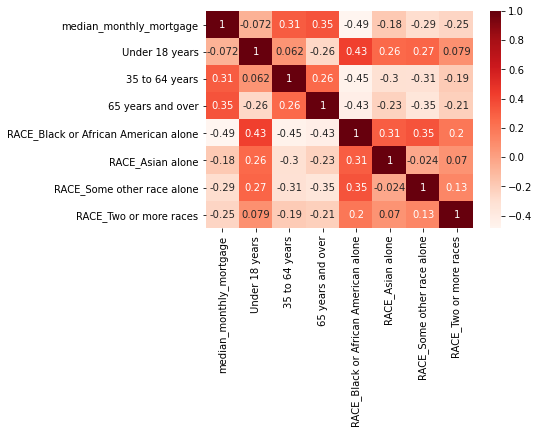

In [16]:
# collinearity check
cor = selected_X1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()